In [1]:
import numpy as np
import laserhockey.hockey_env as h_env
import gymnasium as gym
from importlib import reload
from TD3_helpers import *
import time
import torch
import DDPG
import TD3
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

In [2]:
plt.rcParams.update({'font.size': 6})

In [3]:
np.set_printoptions(suppress=True)
reload(h_env)

C:\Users\lenna\anaconda3\envs\rl-proj\lib\site-packages\gymnasium\envs\registration.py:693: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
C:\Users\lenna\anaconda3\envs\rl-proj\lib\site-packages\gymnasium\envs\registration.py:693: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


<module 'laserhockey.hockey_env' from 'C:\\Users\\lenna\\Desktop\\RL\\Project\\RL-Hockey\\laserhockey\\hockey_env.py'>

In [4]:
start_config = {
    "name" : "name",
    "agent_type" : "TD3",
    "env_type" : "hockey",
    "test" : False,
    "render" : False,
    "episodes" : 400,
    "mode" : "normal",
    "eps" : 0.1,
    "discount":0.99,
    "update_target_every":100,
    "update_policy_every":2,
    "hidden_sizes_actor" : [256,256],
    "hidden_sizes_critic" : [256,256],
    "iter_fit" : 1,
    "batch_size" : 256,
    "smoothing_std"  : 0.0002,
    "smoothing_clip" : 0.0005,
    "checkpoint1" : None,
    "checkpoint2" : None,
    "learning_rate_critic": 0.001,
    "learning_rate_actor": 0.001,
    "buffer_size" : int(1e6),
    "theta" : 0.005,
    "prio_replay" : False,
    "exp_decay" : 1,
    "cdq" : True
}
# lr of 0.0001 for both seems to work best for hockey
# lr 0.001 for pendulum
# iter_fit 40 for walker, 20 for rest
# eps 0.1 seems to be best
# discount 1 shows best results (winning later isn't worse than earlier?)
# 20 iterations with policy delay 2 best for hockey

AGENT TD3


Training...: 100%|███████████████████████████████████████████████████████████████| 50/50 [07:35<00:00,  9.11s/episodes]


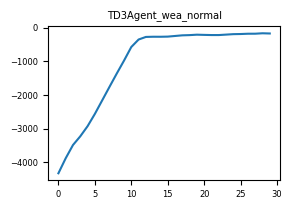

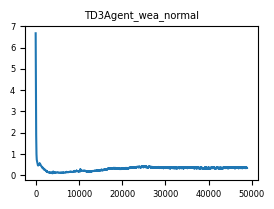

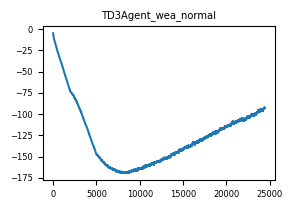

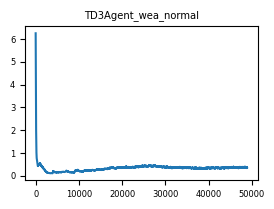

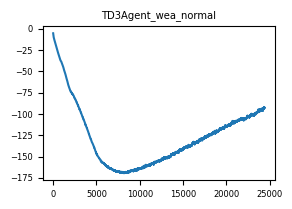

AGENT DDPG


Training...: 100%|███████████████████████████████████████████████████████████████| 50/50 [04:58<00:00,  5.97s/episodes]


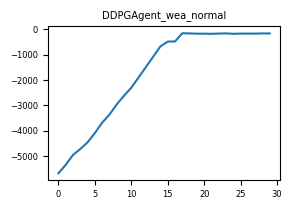

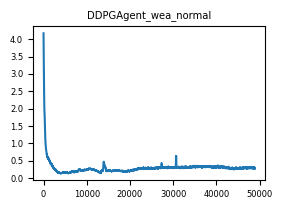

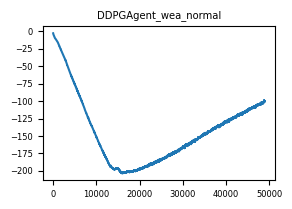

AGENT DPU


Training...: 100%|███████████████████████████████████████████████████████████████| 50/50 [05:09<00:00,  6.20s/episodes]


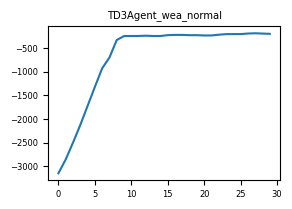

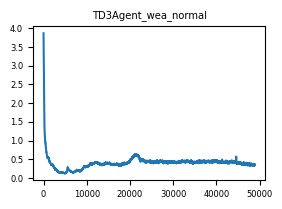

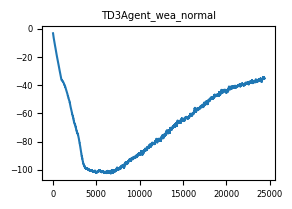

AGENT TPS


Training...: 100%|███████████████████████████████████████████████████████████████| 50/50 [05:33<00:00,  6.66s/episodes]


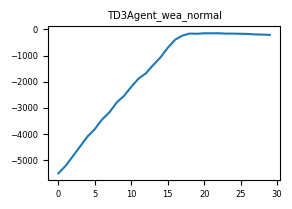

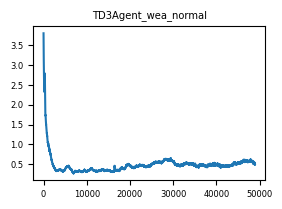

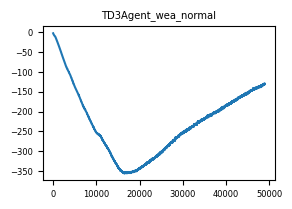

AGENT CDQ


Training...: 100%|███████████████████████████████████████████████████████████████| 50/50 [08:19<00:00,  9.99s/episodes]


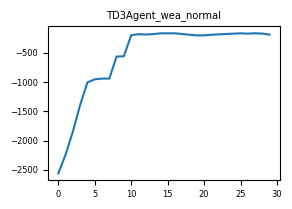

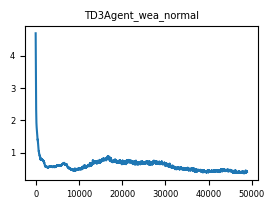

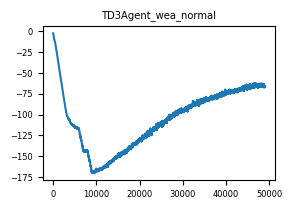

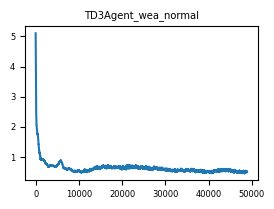

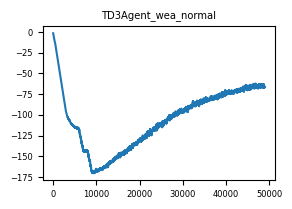

In [6]:
### PENDULUM EXPERIMENT ###
for agent_type in ["TD3", "DDPG", "DPU", "TPS", "CDQ"]:
    print("AGENT", agent_type)
    config = start_config.copy()
    config["discount"] = 0.99
    config["episodes"] = 50
    config["hidden_sizes_critic"] = [32,32]
    config["hidden_sizes_actor"] = [32,32]
    config["learning_rate_critic"] = 0.001
    config["learning_rate_actor"] = 0.001
    config["agent_type"] = agent_type
    config["env_type"] = "pendulum"
    config["name"] = "pendulum new"
    init_train(config)

In [ ]:
### TRAINING CAMP ###
config = start_config.copy()
# defense training
config["name"] = "traincamp_new"
config["env_type"] = "hockey"
config["mode"] = "defense"
config["episodes"] = 500
init_train(config)
config["checkpoint1"] = f'./results/{config["agent_type"]}_hockey_{config["name"]}_{config["mode"]}_agent.pth'
# test agent trained on defense
config["mode"] = "weak"
config["test"] = True
init_train(config)

# shoot training
config["mode"] = "attack"
config["episodes"] = 500
config["test"] = False
init_train(config)
config["checkpoint1"] = f'./results/{config["agent_type"]}_hockey_{config["name"]}_{config["mode"]}_agent.pth'
# test agent trained on defense AND shooting
config["mode"] = "weak"
config["test"] = True
init_train(config)

# regular training
config["mode"] = "weak"
config["episodes"] = 1000
config["test"] = False
init_train(config)
config["checkpoint1"] = f'./results/{config["agent_type"]}_hockey_{config["name"]}_{config["mode"]}_agent.pth'
# test agent trained on defense AND shooting
config["mode"] = "normal"
config["test"] = True
init_train(config)

# regular training
config["mode"] = "normal"
config["episodes"] = 1000
config["test"] = False
init_train(config)
config["checkpoint1"] = f'./results/{config["agent_type"]}_hockey_{config["name"]}_{config["mode"]}_agent.pth'
# test agent trained on defense AND shooting
config["mode"] = "normal"
config["test"] = True
init_train(config)

AGENT TD3


Training...: 100%|█████████████████████████████████████████████████████████████| 100/100 [48:15<00:00, 28.95s/episodes]


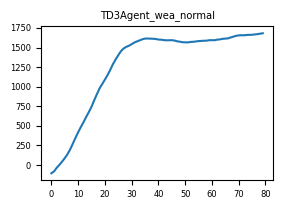

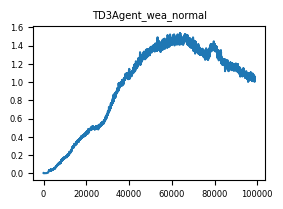

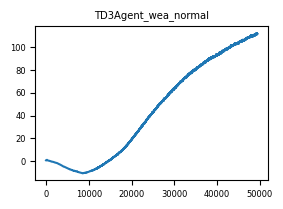

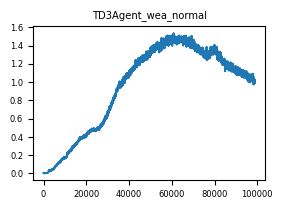

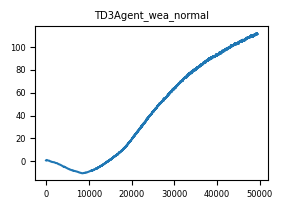

AGENT DDPG


Training...: 100%|█████████████████████████████████████████████████████████████| 100/100 [28:58<00:00, 17.39s/episodes]


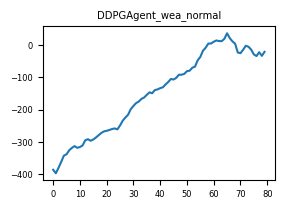

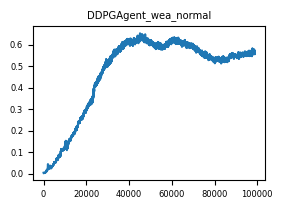

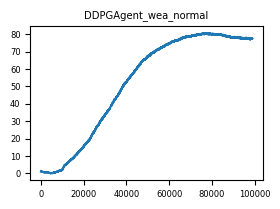

AGENT DPU


Training...:  32%|███████████████████▊                                          | 32/100 [06:57<14:46, 13.04s/episodes]


KeyboardInterrupt: 

In [5]:
### CHEETAH EXPERIMENT ###
for agent_type in [ "TD3", "DDPG", "DPU", "TPS", "CDQ"]:
    print("AGENT", agent_type)
    config = start_config.copy()
    config["discount"] = 0.99
    config["episodes"] = 100
    config["learning_rate_critic"] = 0.001
    config["learning_rate_actor"] = 0.001
    config["agent_type"] = agent_type
    config["env_type"] = "cheetah"
    config["name"] = "agentcompare"
    init_train(config)

In [11]:
### WEAK EXPERIMENT ###
for agent_type in ["TD3", "DDPG", "DPU", "TPS", "CDQ"]:
    print("AGENT", agent_type)
    config = start_config.copy()
    config["discount"] = 0.99
    config["learning_rate_critic"] = 0.001
    config["learning_rate_actor"] = 0.001
    config["smoothing_std"] = 0.0001
    config["smoothing_clip"] = 0.0002
    config["episodes"] = 1000
    config["agent_type"] = agent_type
    config["env_type"] = "hockey"
    config["mode"] = "weak"
    config["name"] = f'agent_compare_newsmooth_ou'
    init_train(config)
    config["checkpoint1"] = f'./results/{config["agent_type"]}_hockey_{config["name"]}_{config["mode"]}_agent.pth'
    config["test"] = True
    init_train(config)

AGENT TD3


Training...:   5%|███▎                                                         | 54/1000 [00:29<08:36,  1.83episodes/s]


KeyboardInterrupt: 

In [ ]:
### NORMAL EXPERIMENT ###
for agent_type in ["TD3", "DDPG", "DPU", "TPS", "CDQ"]:
    print("AGENT", agent_type)
    config = start_config.copy()
    config["discount"] = 0.99
    config["learning_rate_critic"] = 0.0001
    config["learning_rate_actor"] = 0.0001
    #config["smoothing_std"] = 0.0001
    #config["smoothing_clip"] = 0.0002
    config["episodes"] = 400
    config["agent_type"] = agent_type
    config["env_type"] = "hockey"
    config["mode"] = "normal"
    config["name"] = f'agent_compare'
    init_train(config)
    config["checkpoint1"] = f'./results/{config["agent_type"]}_hockey_{config["name"]}_{config["mode"]}_agent.pth'
    config["test"] = True
    init_train(config)

In [ ]:
### PENDULUM EXPERIMENT ###
for agent_type in ["DDPG", "DPU", "TPS", "CDQ", "TD3"]:
    print("AGENT", agent_type)
    config = start_config.copy()
    config["discount"] = 0.95
    config["episodes"] = 5000
    config["learning_rate_critic"] = 0.001
    config["learning_rate_actor"] = 0.001
    config["agent_type"] = agent_type
    config["env_type"] = "pendulum"
    config["name"] = "agentcompare"
    init_train(config)

In [ ]:
### WALKER EXPERIMENT ###
for agent_type in ["DDPG", "DPU", "TPS", "CDQ", "TD3"]:
    print("AGENT", agent_type)
    config = start_config.copy()
    config["iter_fit"] = 40
    config["episodes"] = 5000
    config["learning_rate_critic"] = 0.0001
    config["learning_rate_actor"] = 0.0001
    config["agent_type"] = agent_type
    config["env_type"] = "walker"
    config["name"] = "agentcompare"
    init_train(config)
    config["checkpoint1"] = f'./results/{config["agent_type"]}_{config["env_type"]}_{config["name"]}_{config["mode"]}_agent.pth'

AGENT TD3


Training...: 100%|███████████████████████████████████████████████████████████| 1000/1000 [20:24<00:00,  1.22s/episodes]


Wins: 165
Losses: 467
W/L: 0.3533190578158458


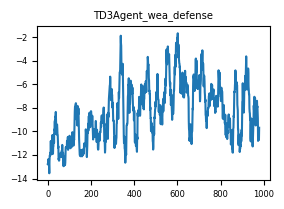

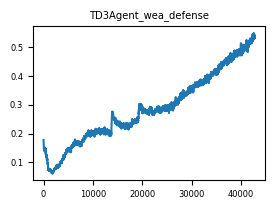

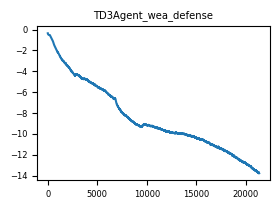

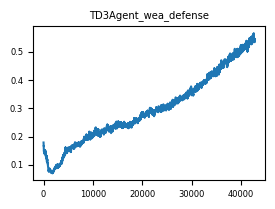

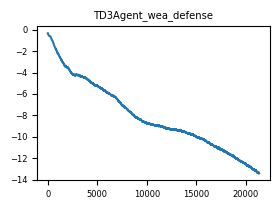

Testing...: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.89episodes/s]


Wins: 214
Losses: 437
W/L: 0.4897025171624714
AGENT DDPG


Training...:   5%|███                                                          | 51/1000 [00:00<00:14, 65.35episodes/s]


AttributeError: 'DDPGAgent' object has no attribute 'Q_target1'

In [5]:
### DEFENSE EXPERIMENT ###
for agent_type in ["TD3", "DDPG", "DPU", "TPS", "CDQ"]:
    print("AGENT", agent_type)
    config = start_config.copy()
    config["episodes"] = 1000
    config["agent_type"] = agent_type
    config["env_type"] = "hockey"
    config["mode"] = "defense"
    config["name"] = "agentcompare_new"
    init_train(config)
    config["checkpoint1"] = f'./results/{config["agent_type"]}_hockey_{config["name"]}_{config["mode"]}_agent.pth'
    config["test"] = True
    init_train(config)

In [ ]:
### ATTACK EXPERIMENT ###
for agent_type in ["DDPG", "DPU", "TPS", "CDQ", "TD3"]:
    print("AGENT", agent_type)
    config = start_config.copy()
    config["episodes"] = 1000
    config["agent_type"] = agent_type
    config["env_type"] = "hockey"
    config["mode"] = "attack"
    config["name"] = f'env_{config["env_type"]}_agent_{agent_type}'
    init_train(config)
    config["checkpoint1"] = f'./results/{config["agent_type"]}_hockey_{config["name"]}_{config["mode"]}_agent.pth'

In [ ]:
config = start_config.copy()
config["episodes"] = 1000
config["env_type"] = "hockey"
config["name"] = f"walker"
config["mode"] = "normal"
agent_type="TD3"
init_train(config)
'''config["checkpoint1"] = f'./results/{agent_type}_hockey_{config["name"]}_{config["mode"]}_agent.pth'
# test agent
config["mode"] = "normal"
config["test"] = True
#config["episodes"] = 10
#config["render"] = True
init_train(agent_type, env_type, config)'''

In [ ]:

for pri in [True, False]:
    config = start_config.copy()
    config["episodes"] = 5000
    config["prio_replay"] = pri
    config["name"] = f"prio_{pri}"
    config["mode"] = "normal"
    agent_type="TD3"
    env_type="hockey"
    init_train(agent_type, env_type, config)
    config["checkpoint1"] = f'./results/{agent_type}_hockey_{config["name"]}_{config["mode"]}_agent.pth'
    # test agent
    config["mode"] = "normal"
    config["test"] = True
    #config["episodes"] = 10
    #config["render"] = True
    init_train(agent_type, env_type, config)

In [ ]:
agent = "TD3Agent"
env = "hockey"
name = "iter20_up_ev2"
mode = "normal"
with (open(f"results/{agent}_{env}_{name}_{mode}_train_stats.pkl", "rb")) as openfile:
    loaded_stats = pickle.load(openfile)
print(loaded_stats["Experiment setup"])
rewards = loaded_stats["Rewards"]
plt.plot(moving_average(rewards,100))

In [ ]:
### training without defense/attack ###

for gamma in [0.99, 0.97, 0.95]:
    config = start_config.copy()
    config["name"] = "discount_new"
    config["discount"] = gamma
    config["episodes"] = 5000
    config["mode"] = "normal"
    init_train(config)
    config["checkpoint1"] = f'./results/TD3Agent_hockey_{config["name"]}_{config["mode"]}_agent.pth'
    # test agent
    config["test"] = True
    config["episodes"] = 5000
    init_train(config)


config = start_config.copy()
for lr in [0.001, 0.0005, 0.0001, 0.00005, 0.00001]:
    config = start_config.copy()
    config["episodes"] = 5000
    config["learning_rate_critic"] = lr
    config["learning_rate_actor"] = lr
    #config["use_target_net"] = False
    config["name"] = f"lr_slidewin"
    config["mode"] = "normal"
    init_train(config)
    config["checkpoint1"] = f'./results/TD3Agent_hockey_{config["name"]}_{config["mode"]}_agent.pth'
    # test agent
    config["mode"] = "normal"
    config["test"] = True
    #config["episodes"] = 10
    #config["render"] = True
    init_train(config)
    config["test"] = False


'''for lr_crit in [0.001, 0.0001, 0.00001]:
    config = start_config.copy()
    config["name"] = "paramtest4"
    config["mode"] = "normal"
    print("LR CRITIC:", lr_crit)
    config["learning_rate_critic"] = lr_crit
    init_train(config)
    config["checkpoint1"] = f'./results/TD3Agent_hockey_{config["name"]}_{config["mode"]}_agent.pth'
    # test agent
    config["mode"] = "normal"
    config["test"] = True
    init_train(config)
    config["test"] = False'''

In [ ]:
env = h_env.HockeyEnv()
agent1 = TD3.TD3Agent(env.observation_space, env.action_space, discount=config["discount"], eps=config["eps"],
                          update_target_every=config["update_target_every"], update_policy_every=config["update_policy_every"], 
                          hidden_sizes_actor=config["hidden_sizes_actor"],hidden_sizes_critic=config["hidden_sizes_critic"],
                          smoothing_std=config["smoothing_std"], smoothing_clip=config["smoothing_clip"],
                          learning_rate_actor=config["learning_rate_actor"], learning_rate_critic=config["learning_rate_critic"])
env.close()
#print(agent1.Q1.state_dict)
Q2 = agent1.Q_target1.parameters()
for ii, param in enumerate(agent1.Q1.parameters()):
    print(ii)
    print("q1",param)
    with torch.no_grad():
        param +=1
    #print(next(Q2))
for ii, param in enumerate(agent1.Q1.parameters()):
    print(ii)
    print("q1",param)

In [ ]:
# selfplay
config = start_config.copy()
config["episodes"] = 1000
config["name"] = "20ktest"
for i in range(1):
    if i>0:
        config["mode"] = "selfplay"
    config["checkpoint1"] = f'./results/TD3Agent_hockey_{config["name"]}_{config["mode"]}_agent.pth'
    config["checkpoint2"] = f'./results/TD3Agent_hockey_{config["name"]}_{config["mode"]}_agent.pth'
    config["name"] = f"selfplay{i}"
    config["mode"] = "selfplay"
    config["test"] = False
    init_train(config)
    config["test"] = True
    config["mode"] = "normal"
    config["checkpoint2"] = None
    init_train(config)

In [ ]:
### TRAINING CAMP ###
config = start_config.copy()
# defense training
config["name"] = "traincamp_new"
config["mode"] = "defense"
config["episodes"] = 1000
init_train(config)
config["checkpoint1"] = f'./results/TD3Agent_hockey_{config["name"]}_{config["mode"]}_agent.pth'
# test agent trained on defense
config["mode"] = "normal"
config["test"] = True
init_train(config)

# shoot training
config["mode"] = "attack"
config["test"] = False
init_train(config)
config["checkpoint1"] = f'./results/TD3Agent_hockey_{config["name"]}_{config["mode"]}_agent.pth'
# test agent trained on defense AND shooting
config["mode"] = "normal"
config["test"] = True
init_train(config)

# regular training
config["mode"] = "normal"
config["test"] = False
init_train(config)
config["checkpoint1"] = f'./results/TD3Agent_hockey_{config["name"]}_{config["mode"]}_agent.pth'
# test agent trained on defense AND shooting
config["mode"] = "normal"
config["test"] = True
init_train(config)